In [1]:
import pandas as pd
import numpy as np

import fml
%matplotlib inline

This notebook implements the Triple barrier labeling method presented in Chapter 3.4 of the book "Advances in financial machine learning".

# Data preparation

In [2]:
df_price = fml.DataHandler().get_time_series_data("SPY")
price = fml.DailyPrice(df_price["Adj Close"])
df_price.tail()

,Open,High,Low,Close,Volume,Dividend,Split,Adj Open,Adj High,Adj Low,Adj Close,Adj Volume
Date,,,,,,,,,,,,
2018-03-27,266.17,266.77,258.8400,260.60,129941445.0,0.0,1.0,266.17,266.77,258.8400,260.60,129941445.0
2018-03-28,260.75,262.64,258.5800,259.83,146452306.0,0.0,1.0,260.75,262.64,258.5800,259.83,146452306.0
2018-03-29,261.12,265.26,259.8389,263.15,124244790.0,0.0,1.0,261.12,265.26,259.8389,263.15,124244790.0
2018-04-02,262.55,263.13,254.6700,257.47,186286343.0,0.0,1.0,262.55,263.13,254.6700,257.47,186286343.0
2018-04-03,258.87,261.31,256.8400,260.77,119889222.0,0.0,1.0,258.87,261.31,256.8400,260.77,119889222.0


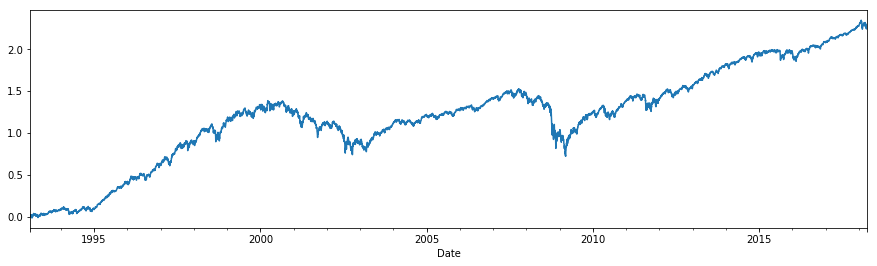

In [3]:
ret = price.pct_change
np.log(1. + ret).cumsum().plot(figsize=(15, 4))

In [4]:
vol = price.rolling_vol(100, min_periods=1)
rolling_mean = ret.rolling(100, min_periods=1).mean()
df = ret.to_frame("ret")

In [5]:
df["upper_bound"] = rolling_mean + 1. * vol
df["lower_bound"] = rolling_mean - 1. * vol

#  Iterative implementation

In [6]:
window = 10
for i in range(100, 115 - window):
    perf = (ret[i + 1:i + window + 1] + 1.).cumprod() - 1
    print i, df["upper_bound"][i], df["lower_bound"][i], perf
    upper_bound_cross = perf[perf > df["upper_bound"][i]]
    upper_ind = window if len(upper_bound_cross) == 0 else upper_bound_cross[0]
    lower_bound_cross = perf[perf < df["lower_bound"][i]]
    lower_ind = window if len(lower_bound_cross) == 0 else lower_bound_cross[0]
    if window == upper_ind == lower_ind:
        print perf[-1] > 0
    else:
        print upper_ind < lower_ind

100 0.00717878607089 -0.00664023857766 Date
1993-06-21    0.002106
1993-06-22    0.002809
1993-06-23   -0.006321
1993-06-24    0.007022
1993-06-25    0.006319
1993-06-28    0.017555
1993-06-29    0.012640
1993-06-30    0.012640
1993-07-01    0.009831
1993-07-02    0.004213
Freq: B, Name: Adj Close, dtype: float64
True
101 0.00709669700525 -0.00665828466312 Date
1993-06-22    0.000702
1993-06-23   -0.008409
1993-06-24    0.004907
1993-06-25    0.004205
1993-06-28    0.015417
1993-06-29    0.010513
1993-06-30    0.010513
1993-07-01    0.007710
1993-07-02    0.002103
1993-07-05    0.002103
Freq: B, Name: Adj Close, dtype: float64
False
102 0.00708005042554 -0.00666995050856 Date
1993-06-23   -0.009105
1993-06-24    0.004202
1993-06-25    0.003500
1993-06-28    0.014705
1993-06-29    0.009804
1993-06-30    0.009804
1993-07-01    0.007003
1993-07-02    0.001401
1993-07-05    0.001401
1993-07-06   -0.009105
Freq: B, Name: Adj Close, dtype: float64
False
103 0.00686513466254 -0.00684856926362

# Vectorization with pandas

In [7]:
cols_window = list(range(1, window + 1))
for i in cols_window:
    df[i] = ret.rolling(i).apply(lambda p: np.prod(1. + p) - 1).shift(-i)

In [8]:
cols = list(df.drop("ret", axis=1).columns)
cols

['upper_bound', 'lower_bound', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [9]:
import operator
def get_ind(p, col="upper_bound"):
    op = operator.gt if col == "upper_bound" else operator.lt
    cross_bound = op(p[cols_window], p[col])
    ind = cross_bound[cross_bound].index
    return window + 1 if len(ind) == 0 else ind[0]
    
df["upper_ind"] = df[cols].apply(lambda p: get_ind(p, "upper_bound"), axis=1)
df["lower_ind"] = df[cols].apply(lambda p: get_ind(p, "lower_bound"), axis=1)

In [10]:
# when upper bound is crossed first
df["label"] = df["upper_ind"] < df["lower_ind"]

# As when there's any bound touch, upper_ind and lower_ind should be different
select_no_touch = df["upper_ind"] == df["lower_ind"]
df.loc[select_no_touch, "label"] = df.loc[select_no_touch, window] > 0

# Validatation

In [11]:
df.loc[df["upper_ind"] == df["lower_ind"]].drop(range(1, window), axis=1).tail(10)

,ret,upper_bound,lower_bound,10,upper_ind,lower_ind,label
Date,,,,,,,
2017-07-25,0.002431,0.004980,-0.003915,-0.000647,11,11,False
2017-07-26,0.000040,0.004993,-0.003890,-0.000727,11,11,False
2017-07-27,-0.000930,0.004972,-0.003914,-0.013916,11,11,False
2017-09-12,0.003371,0.005193,-0.004132,0.001058,11,11,True
2017-09-13,0.000480,0.005203,-0.004120,0.004474,11,11,True
2017-09-14,-0.000320,0.005192,-0.004132,0.006001,11,11,True
2017-09-15,0.001340,0.005220,-0.004090,0.008187,11,11,True
2017-10-05,0.005925,0.005118,-0.003446,0.004437,11,11,True
2017-12-19,-0.003840,0.005077,-0.003315,0.005989,11,11,True


In [12]:
df.loc[df["upper_ind"] != df["lower_ind"]].tail(20)

,ret,upper_bound,lower_bound,1,2,3,4,5,6,7,8,9,10,upper_ind,lower_ind,label
Date,,,,,,,,,,,,,,,,
2018-03-06,0.002535,0.009384,-0.007889,-0.000366,0.004471,0.021951,0.020668,0.014072,0.008868,0.007769,0.008857,-0.004793,-0.003100,3,11,True
2018-03-07,-0.000366,0.009371,-0.007903,0.004839,0.022326,0.021043,0.014444,0.009238,0.008138,0.009227,-0.004428,-0.002735,-0.004649,2,11,True
2018-03-08,0.004839,0.009426,-0.007867,0.017402,0.016126,0.009559,0.004378,0.003283,0.004367,-0.009222,-0.007537,-0.009442,-0.034203,1,7,True
2018-03-09,0.017402,0.009697,-0.007893,-0.001255,-0.007710,-0.012802,-0.013877,-0.012812,-0.026169,-0.024513,-0.026385,-0.050723,-0.070956,11,3,False
2018-03-12,-0.001255,0.009713,-0.007856,-0.006463,-0.011561,-0.012638,-0.011572,-0.024946,-0.023287,-0.025162,-0.049530,-0.069789,-0.044339,11,2,False
2018-03-13,-0.006463,0.009661,-0.007969,-0.005132,-0.006216,-0.005142,-0.018603,-0.016934,-0.018821,-0.043348,-0.063738,-0.038123,-0.054486,11,4,False
2018-03-14,-0.005132,0.009660,-0.007972,-0.001090,-0.000011,-0.013541,-0.011863,-0.013760,-0.038413,-0.058909,-0.033162,-0.049609,-0.052417,11,3,False
2018-03-15,-0.001090,0.009639,-0.007997,0.001080,-0.012465,-0.010785,-0.012684,-0.037364,-0.057882,-0.032107,-0.048572,-0.051384,-0.039263,11,2,False
2018-03-16,0.001080,0.009536,-0.008037,-0.013530,-0.011853,-0.013749,-0.038403,-0.058899,-0.033151,-0.049599,-0.052407,-0.040299,-0.040299,11,1,False


In [13]:
df.loc[df["upper_bound"].isnull()]

,ret,upper_bound,lower_bound,1,2,3,4,5,6,7,8,9,10,upper_ind,lower_ind,label
Date,,,,,,,,,,,,,,,,
1993-01-29,NaN,NaN,NaN,0.007112,0.009245,0.019915,0.024182,0.023470,0.02347,0.016357,0.017780,0.022760,0.014935,11,11,True
1993-02-01,0.007112,NaN,NaN,0.002118,0.012712,0.016949,0.016242,0.016242,0.00918,0.010592,0.015537,0.007767,0.007767,11,11,True
